# [自然语言处理入门](https://github.com/FudanNLP/nlp-beginner)

## 任务一：基于机器学习的文本分类

实现基于logistic/softmax regression的文本分类

1. 参考
   1. [文本分类](文本分类.md)
   2. 《[神经网络与深度学习](https://nndl.github.io/)》 第2/3章
2. 数据集：[Classify the sentiment of sentences from the Rotten Tomatoes dataset](https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews)
3. 实现要求：NumPy
4. 需要了解的知识点：

   1. 文本特征表示：Bag-of-Word，N-gram
   2. 分类器：logistic/softmax  regression，损失函数、（随机）梯度下降、特征选择
   3. 数据集：训练集/验证集/测试集的划分
5. 实验：
   1. 分析不同的特征、损失函数、学习率对最终分类性能的影响
   2. shuffle 、batch、mini-batch 
6. 时间：两周

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1

basic-text-classification.ipynb  text-classification-nn.ipynb
data				 text-classification-TF-IDF.ipynb
text-classification-BoW.ipynb


### 神经网络

In [3]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# 读取 TSV 文件并转成 Dataset
def load_dataset(path):
  data = pd.read_csv(path, delimiter='\t', encoding='utf-8')
  return data # tf.data.Dataset.from_tensor_slices((data['Phrase'].values, data['Sentiment'].values))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


Version:  2.4.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [4]:
TRAIN_FILE_PATH='/content/drive/MyDrive/NaturalLanguageProcessing/nlp-beginner/task-1/data/train.tsv'

# 读取文件
dataset = load_dataset(TRAIN_FILE_PATH)

In [5]:
dataset

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [6]:
# 准备数据
raw_id = dataset['SentenceId'].values
raw_data = dataset['Phrase'].values
raw_label = dataset['Sentiment'].values
data = []
label = []
index = 1
for i in np.arange(len(raw_data)):
  if raw_id[i] < index:
    continue
  if index < raw_id[i]:
    index = raw_id[i]
  data.append(raw_data[i])
  if raw_label[i] > 2:
    label.append(1)
  else:
    label.append(0)
  index = index + 1
label = np.array(label)

In [7]:
data[:4]

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'This quiet , introspective and entertaining independent is worth seeking .',
 "Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",
 'A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .']

In [8]:
label[:4]

array([0, 1, 0, 1])

In [9]:
# 划分训练集与测试集
train_examples = data[:8000]
train_labels = label[:8000]
test_examples = data[8000:]
test_labels = label[8000:]

In [10]:
vectorizer = TfidfVectorizer(min_df=5, stop_words=stop_words.ENGLISH_STOP_WORDS)
vec = vectorizer.fit(data)
train_vec = vec.transform(train_examples).toarray()
test_vec = vec.transform(test_examples).toarray()

In [11]:
train_vec[:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
#
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1))

In [13]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [14]:
x_val = train_vec[:7000]
partial_x_train = train_vec[7000:]

y_val = train_labels[:7000]
partial_y_train = train_labels[7000:]

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=5,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
2/2 [==============================] - 4s 752ms/step - loss: 0.6924 - accuracy: 0.5155 - val_loss: 0.6880 - val_accuracy: 0.5837
Epoch 2/5
2/2 [==============================] - 0s 132ms/step - loss: 0.6756 - accuracy: 0.6489 - val_loss: 0.6835 - val_accuracy: 0.5809
Epoch 3/5
2/2 [==============================] - 0s 118ms/step - loss: 0.6596 - accuracy: 0.6700 - val_loss: 0.6793 - val_accuracy: 0.5804
Epoch 4/5
2/2 [==============================] - 0s 124ms/step - loss: 0.6428 - accuracy: 0.7176 - val_loss: 0.6752 - val_accuracy: 0.5829
Epoch 5/5
2/2 [==============================] - 0s 122ms/step - loss: 0.6253 - accuracy: 0.7685 - val_loss: 0.6710 - val_accuracy: 0.5880


In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

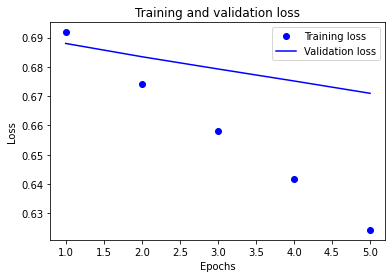

In [17]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

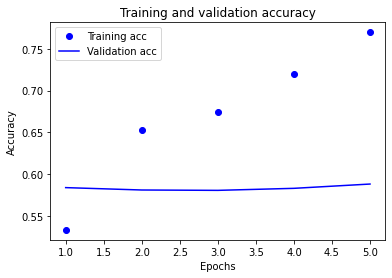

In [18]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()